# Data Import

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (recall_score,log_loss)
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.metrics import classification_report

In [0]:
from google.colab import drive
drive.mount('/content/Drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/Drive


In [0]:
data = pd.read_csv('/content/Drive/My Drive/Colab Notebooks/1000ml/Unit2/Project4/hr-data.csv')

# Data Cleaning

In [0]:
data.dtypes

id                         int64
satisfaction_level       float64
last_evaluation          float64
number_project             int64
average_montly_hours       int64
time_spend_company         int64
Work_accident              int64
churn                      int64
promotion_last_5years      int64
sales                     object
salary                    object
dtype: object

In [0]:
data.isnull().sum()

id                       0
satisfaction_level       0
last_evaluation          0
number_project           0
average_montly_hours     0
time_spend_company       0
Work_accident            0
churn                    0
promotion_last_5years    0
sales                    0
salary                   0
dtype: int64

# EDA

In [0]:
data.shape

(14999, 11)

In [0]:
data.head(2)

,id,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,churn,promotion_last_5years,sales,salary
0,0,0.38,0.53,2,157,3,0,1,0,sales,low
1,1,0.80,0.86,5,262,6,0,1,0,sales,medium


## Aggregate Statistics

* For employees that have churned:
  * satisfaction is lower
  * Monthly hours are higher
  * Time spent with the company is higher
  * Number of promotions are lower
  * Accidents are lower

* `high`-`salary` employees have churned less
* `management` and `RandD` have less churns than the other `sales`

In [0]:
def stats(variable):
  '''
  Displays the means across all numerical variables grouped for the given variable
  '''
  return data.groupby(variable).mean()

In [0]:
data.nunique()

id                       14999
satisfaction_level          92
last_evaluation             65
number_project               6
average_montly_hours       215
time_spend_company           8
Work_accident                2
churn                        2
promotion_last_5years        2
sales                       10
salary                       3
dtype: int64

In [0]:
stats('churn')

,id,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,promotion_last_5years,sales,salary
churn,,,,,,,,,,
0,7811.340742,0.666810,0.715473,3.786664,199.060203,3.380032,0.175009,0.026251,1.0,0.0
1,6499.439653,0.440098,0.718113,3.855503,207.419210,3.876505,0.047326,0.005321,1.0,0.0


In [0]:
stats(categorical_variables[0])

,id,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,churn,promotion_last_5years,sales,salary
Work_accident,,,,,,,,,,
0,7470.638893,0.606833,0.716602,3.805456,201.258613,3.496960,0.265160,0.018940,1.0,0.0
1,7666.760719,0.648326,0.713144,3.788843,199.818349,3.505763,0.077916,0.035039,1.0,0.0


In [0]:
stats(categorical_variables[1])

,id,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,churn,sales,salary
promotion_last_5years,,,,,,,,,,
0,7442.197820,0.611895,0.716321,3.804155,201.076431,3.483719,0.142575,0.241962,1.0,0.0
1,10112.968652,0.656019,0.706019,3.752351,199.849530,4.166144,0.238245,0.059561,1.0,0.0


In [0]:
stats(categorical_variables[2])

,id,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,churn,promotion_last_5years,salary
sales,,,,,,,,,,
1,7499.0,0.612834,0.716102,3.803054,201.050337,3.498233,0.14461,0.238083,0.021268,0.0


In [0]:
stats(categorical_variables[3])

,id,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,churn,promotion_last_5years,sales
salary,,,,,,,,,,
0,7499.0,0.612834,0.716102,3.803054,201.050337,3.498233,0.14461,0.238083,0.021268,1.0


It seems that employees in the high salary bracket are less likely to churn.

## Feedback

I should avoid displaying the mean of categorical/binary columns if they were numerically encoded if possible.

In [0]:
#Setting what the categorical, numerical, and target variables are

categorical_variables = ['Work_accident','promotion_last_5years','sales','salary']

numerical_variables = ['id','satisfaction_level','last_evaluation',
                       'average_montly_hours','number_project','time_spend_company']

target = 'Churn'

## Distributions

* all categorical variables seem good predictors

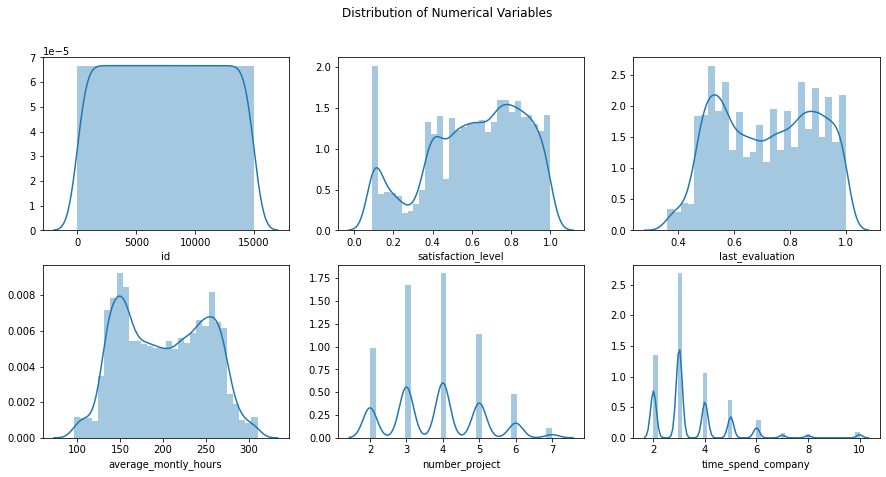

In [0]:
fig, axs = plt.subplots(2,3, figsize=(15,7))

for column, ax in zip(numerical_variables, axs.flatten()):
  sns.distplot(data[column],ax=ax)

plt.suptitle('Distribution of Numerical Variables')
plt.show()

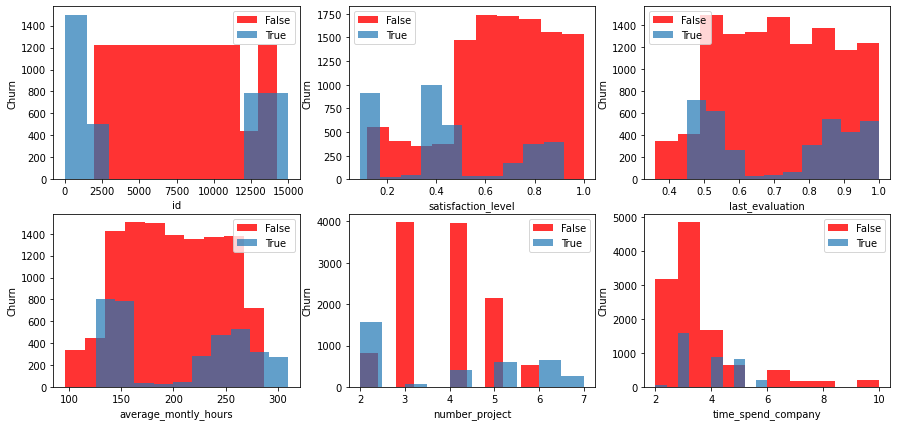

In [0]:
fig, axs = plt.subplots(2,3, figsize=(15,7))

for column, ax in zip(numerical_variables, axs.flatten()):
  ax.hist(data[data['churn']==False][column],label='False',color='red',alpha=0.8)
  ax.hist(data[data['churn']==True][column],label="True",alpha=0.7)

  ax.set_xlabel(column)
  ax.set_ylabel('Churn')
  ax.legend()

plt.show()

## Feedback

I'm not the biggest fan of the above plot (maybe because it seems busy, but it works. I also get the feeling that I'm supposed to be in a 3D movie theatre) but it does seem interesting to see that there is a weird association between employee ID's and churn.

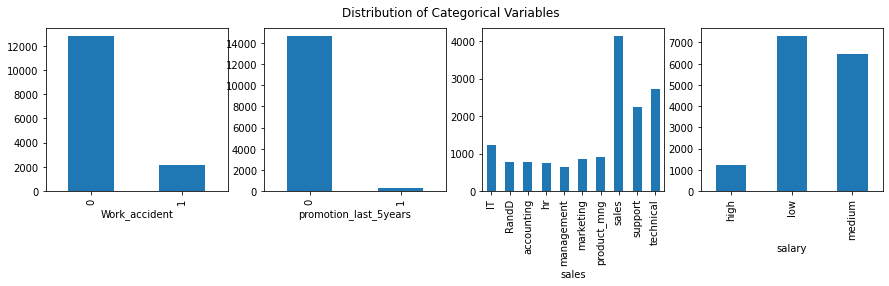

In [0]:
fig, axs = plt.subplots(1,4, figsize=(15,3))

for column, ax in zip(categorical_variables, axs.flatten()):
  data[column].value_counts().sort_index().plot(kind='bar',ax=ax,rot=90)
  ax.set_xlabel(column)

plt.suptitle('Distribution of Categorical Variables')
plt.show()

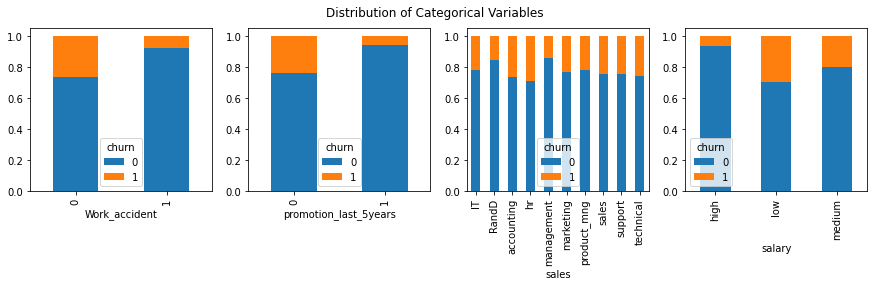

In [0]:
fig, axs = plt.subplots(1,4, figsize=(15,3))

for column, ax in zip(categorical_variables, axs.flatten()):

  table=pd.crosstab(data[column],data['churn'])
  table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True,ax=ax)

  # data[column][data['churn']==False].value_counts().sort_index().plot(kind='bar',ax=ax,rot=90,color='red',alpha=0.8)
  # data[column][data['churn']==True].value_counts().sort_index().plot(kind='bar',ax=ax,rot=90,alpha=0.7)
  ax.set_xlabel(column)

plt.suptitle('Distribution of Categorical Variables')
plt.show()

## Feedback

I am a fan of the above barplot. This clearly shows the proportion of churn victims by categorical variables. Good job here on the analysis too. 

Any possible explanation for churn given what we see from these couple of graphs? It might be obvious, but stating the obvious is better than just not doing it at all in this case.

For sales, we see that RandD and management have lower churn rates than the other categories. We will group those two together and assign values of 0, and 1 for the other categories, in order to reduce the amount of features.

The same will be done with salary, where a high salary has a lower churn rate than low or medium salary. 1 will be assigned to medium and low salaries, 0 to high salaries.

This greatily reduces the amount of variables (read: dummy variables) we have to take into our model.

In [0]:
data['salary'] = np.where(data['salary'].isin(['low','medium']), 1, 0)
data['sales'] = np.where(data['sales'].isin(['RandD','management']), 0, 1)

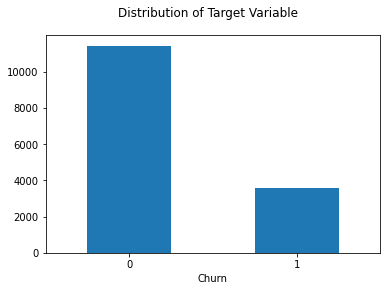

In [0]:
data['churn'].value_counts().sort_index().plot(kind='bar',rot=0)
plt.xlabel('Churn')
plt.suptitle('Distribution of Target Variable')
plt.show()

## Scatterplots

* reveal no significant trends

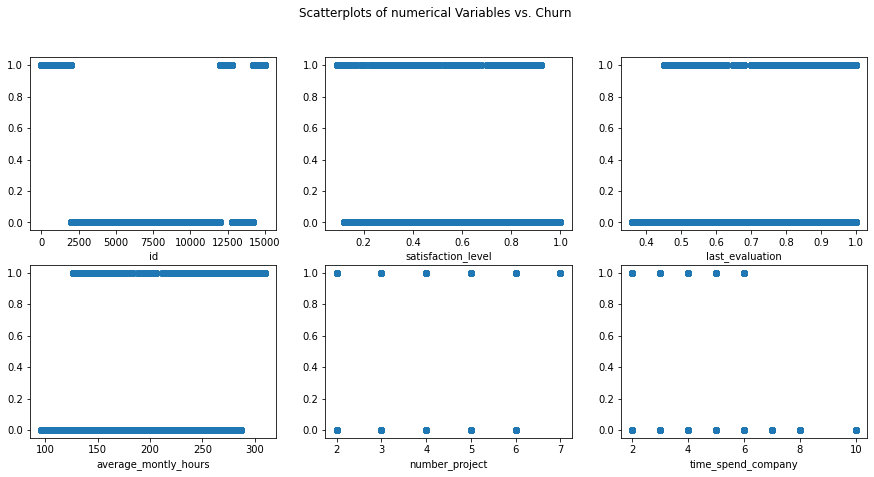

In [0]:
fig, axs = plt.subplots(2,3, figsize=(15,7))

for column, ax in zip(numerical_variables, axs.flatten()):
  ax.scatter(data[column],data['churn'])
  ax.set_xlabel(column)

plt.suptitle('Scatterplots of numerical Variables vs. Churn')
plt.show()

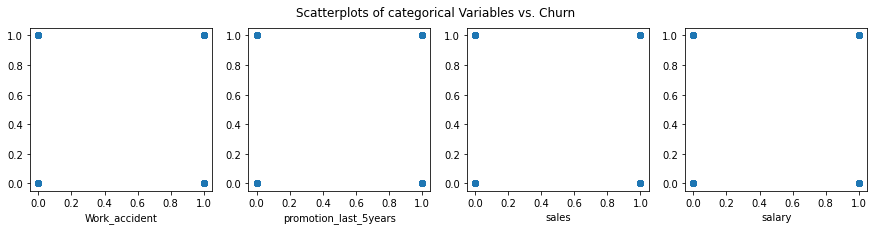

In [0]:
fig, axs = plt.subplots(1,4, figsize=(15,3))

for column, ax in zip(categorical_variables, axs.flatten()):
  ax.scatter(data[column],data['churn'])
  ax.set_xlabel(column)

plt.suptitle('Scatterplots of categorical Variables vs. Churn')
plt.show()

These beautiful scatter plots offer little to no value, great!

#Logistic Regression

Best parameters:
  * 'C': 1e-06 
  * 'class_weight': 'balanced'
  * 'penalty': 'l2'
  * 'solver': 'liblinear'

Performance:
  * Recall Score: 0.834206

###Model 1: Single Variable

Modelling churn with a single variable does not yield any significant results, unfortunately.

In [0]:
def sigmoid_curve(x):
  return 1/(1 + np.exp(-x))

In [0]:
def log_to_prob(num):
  '''
  This function transforms log odds values back to probabilities
  '''
  return np.exp(num) / (1 + np.exp(num))

In [0]:
#set the variable
x = data[['average_montly_hours']]
y = data['churn']

x_train, x_val, y_train, y_val = train_test_split(x,y,
                                                  test_size = 0.2,
                                                  random_state = 42)

#set the model
#clf stands for classifier
clf = LogisticRegression(penalty='none',solver='lbfgs',verbose=2,max_iter=1000)

#fit the model
clf.fit(x_train,y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='none',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=2,
                   warm_start=False)

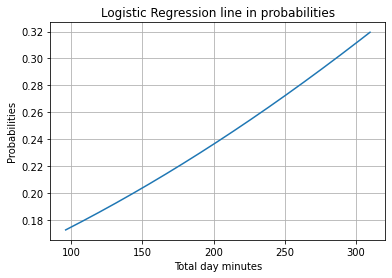

In [0]:
#plotting from minimum to maximum value

x_values = np.arange(x.min()[0],x.max()[0],0.01)

y_values = x_values * clf.coef_[0] + clf.intercept_

plt.plot(x_values,log_to_prob(y_values))
plt.ylabel('Probabilities')
plt.xlabel('Total day minutes')
plt.title('Logistic Regression line in probabilities')
plt.grid()

In [0]:
y_train

9838     0
7689     0
6557     0
6872     0
820      1
        ..
5191     0
13418    0
5390     0
860      1
7270     0
Name: churn, Length: 11999, dtype: int64

In [0]:
# log loss (true y label, with prediction probabilities)
print('Log-Loss')
print(f'Train: {log_loss(  y_train , clf.predict(x_train) ).round(3)}')
print(f'Validation: {log_loss( y_val , clf.predict(x_val) ).round(3)}')
print('-------------')
#Recall Score
print('Recall Score')
print(f'Train: {recall_score( y_train, clf.predict(x_train) ).round(3)}')
print(f'Validation: {recall_score( y_val, clf.predict(x_val) ).round(3)}')

Log-Loss
Train: 8.247
Validation: 8.128
-------------
Recall Score
Train: 0.0
Validation: 0.0


##Grid Search

In [0]:
from sklearn.model_selection import GridSearchCV

We simply try every combinations of different model parameter and see what combination gives us the best recall score.

In [0]:
params_none = {'clf__penalty': ['none'],
               'clf__solver': ['liblinear','lbfgs','newton-cg','sag','saga'],
               'clf__class_weight': ['balanced','unbalanced']}

params_l1 = {'clf__penalty': ['l1'],
             'clf__solver': ['liblinear','lbfgs','newton-cg','sag','saga'],
             'clf__C': np.logspace(-6,1,8),
             'clf__class_weight': ['balanced','unbalanced']}           

params_l2 = {'clf__penalty': ['l2'],
             'clf__solver': ['liblinear','lbfgs','newton-cg','sag','saga'],
             'clf__C': np.logspace(-6,1,8),
             'clf__class_weight': ['balanced','unbalanced']}

params_en = {'clf__penalty': ['elasticnet'],
             'clf__solver': ['liblinear','lbfgs','newton-cg','sag','saga'],
             'clf__C': np.logspace(-6,1,8),
             'clf__l1_ratio': np.arange(0,1,0.01),
             'clf__class_weight': ['balanced','unbalanced']}

In [0]:
x = data.drop(['id','churn'],axis=1)
y = data['churn']

#Train validation data split
x_train, x_val, y_train, y_val = train_test_split(x,y,test_size = 0.2,random_state = 42)

# Set the parameters by cross-validation
super_params = [params_none,params_l1,params_l2,params_en]

#Make pipe, but change solver
pipe = Pipeline(steps = [('scaler', StandardScaler()), 
                        ('clf', LogisticRegression(random_state=42))])

clf = GridSearchCV(pipe, param_grid = super_params, scoring = 'recall',
                   cv=5, n_jobs = -1)

clf.fit(x_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('scaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('clf',
                                        LogisticRegression(C=1.0,
                                                           class_weight=None,
                                                           dual=False,
                                                           fit_intercept=True,
                                                           intercept_scaling=1,
                                                           l1_ratio=None,
                                                           max_iter=100,
                                                           multi_class='auto',
             

In [0]:
clf.best_params_

{'clf__C': 1e-06,
 'clf__class_weight': 'balanced',
 'clf__penalty': 'l2',
 'clf__solver': 'liblinear'}

These are the model parameters that give the highest recall score.

In [0]:
pd.DataFrame(clf.cv_results_).sort_values(by='mean_test_score',ascending=False).transpose()

,90,91,100,110,7669,7309,7314,7319,7324,7329,7334,7339,7344,7349,1,7609,7664,7659,7654,7649,7644,7639,7634,7629,7624,7619,7304,7299,7294,7289,7174,7179,7184,7189,7194,7199,7204,7209,7214,7219,...,8120,8121,8122,8123,8125,8126,8127,8128,8130,8131,8132,8133,8135,8136,8137,8138,8140,8141,8142,8143,8145,8146,8147,8148,8150,8151,8152,8153,8155,8156,8157,8158,8160,8161,8162,8163,8165,8166,8167,8168
mean_fit_time,0.0179735,0.0232378,0.0222447,0.0284808,0.0775555,0.0811333,0.0783953,0.0744114,0.0771128,0.0786051,0.0794761,0.0857143,0.0797426,0.0782685,0.0371087,0.0806954,0.0752542,0.0804397,0.0793311,0.0766763,0.0750774,0.076106,0.0787333,0.0789876,0.0788206,0.0777033,0.0833507,0.0806891,0.0747823,0.0796997,0.0655621,0.0782772,0.0758526,0.0782273,0.0786245,0.0732021,0.0830668,0.0750763,0.0788805,0.0805319,...,0.00834451,0.0062923,0.00720119,0.0105812,0.00677629,0.00793076,0.0065187,0.00783195,0.0152606,0.00870757,0.00634112,0.00864472,0.00662575,0.0141435,0.00637631,0.00672464,0.00749836,0.00637417,0.00866766,0.00660577,0.0074347,0.00832295,0.00697141,0.00713654,0.00690794,0.00716991,0.00821967,0.00704031,0.0127264,0.00675044,0.00768471,0.00759811,0.00689883,0.00634823,0.0069087,0.00682688,0.00774784,0.0084023,0.00968838,0.0108295
std_fit_time,0.000595927,0.00486353,0.000401482,0.0087518,0.00819481,0.0107935,0.0100805,0.00388038,0.00806571,0.00929711,0.0125457,0.0280367,0.0101219,0.011198,0.00257108,0.00854501,0.00266513,0.0108562,0.00932778,0.00754723,0.00620911,0.00662118,0.0100456,0.0095804,0.0110345,0.00493756,0.0182069,0.00497917,0.00362982,0.0118072,0.00668104,0.0130925,0.00344303,0.0115105,0.0121729,0.0034452,0.0193978,0.00689321,0.010627,0.0112552,...,0.0024308,2.66455e-05,0.000420648,0.00312915,0.000391891,0.0031805,0.000238416,0.00140131,0.010196,0.00285011,2.63935e-05,0.00231807,0.000351487,0.00875838,6.57946e-05,0.000447795,0.00156039,8.1885e-05,0.00354826,0.000461538,0.000244061,0.00241738,0.000401243,0.000485342,0.000220866,0.000410326,0.0029769,0.000333377,0.00642534,4.91611e-05,0.000445042,0.000697155,0.000379233,4.92346e-05,0.000576521,0.000507851,0.000273366,0.000919079,0.00447172,0.00614706
mean_score_time,0.00422058,0.00701056,0.00516791,0.00461974,0.00465055,0.00487723,0.00478458,0.00491638,0.00442514,0.00462537,0.00519743,0.00467987,0.00520806,0.00454736,0.0052927,0.00464125,0.00570626,0.00493946,0.00468698,0.00449586,0.00471582,0.00468917,0.00507383,0.0050045,0.00459962,0.00505056,0.0044837,0.00457597,0.00501819,0.0048234,0.00544448,0.0057714,0.00516386,0.00447111,0.00462627,0.00449581,0.00470839,0.00453091,0.00459719,0.00487967,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
std_score_time,0.000301179,0.00546395,0.000231347,0.000336509,0.000376768,0.000427346,0.000234455,0.000230727,0.000334095,0.000420046,0.000321784,0.000172816,0.00023586,0.000154848,0.000295552,0.000289112,0.00204294,0.000299472,0.000321066,0.000390973,0.0002251,0.000390628,0.00140895,0.000249433,0.000279782,0.000163843,0.000330016,0.000338357,0.00086121,0.000220538,0.00171655,0.00249539,0.000302882,0.000297019,0.000398881,0.000291336,0.000402655,0.000285886,0.000303048,0.000485482,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
param_clf__class_weight,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,...,unbalanced,unbalanced,unbalanced,unbalanced,unbalanced,unbalanced,unbalanced,unbalanced,unbalanced,unbalanced,unbalanced,unbalanced,unbalanced,unbalanced,unbalanced,unbalanced,unbalanced,unbalanced,unbalanced,unbalanced,unbalanced,unbalanced,unbalanced,unbalanced,unbalanced,unbalanced,unbalanced,unbalanced,unbalanced,unbalanced,unbalanced,unbalanced,unbalanced,unbal

The first model was selected, as it has the highest mean_test_score and a lower mean_fit_time than the second model in the ranking.

In [0]:
print(classification_report(y_val,clf.predict(x_val)))

              precision    recall  f1-score   support

           0       0.93      0.64      0.76      2294
           1       0.42      0.84      0.56       706

    accuracy                           0.69      3000
   macro avg       0.67      0.74      0.66      3000
weighted avg       0.81      0.69      0.71      3000



The model seems to correctly identify churning employees 75% of the time.

In [0]:
pd.Series(clf.best_estimator_.named_steps['clf'].coef_.round(4)[0],
          index = x.columns)

satisfaction_level      -0.0028
last_evaluation          0.0001
number_project           0.0002
average_montly_hours     0.0006
time_spend_company       0.0010
Work_accident           -0.0011
promotion_last_5years   -0.0004
sales                    0.0000
salary                   0.0000
dtype: float64

#Estimator

In [0]:
#set variables
data['salary'] = np.where(data['salary'].isin(['low','medium']), 1, 0)
data['sales'] = np.where(data['sales'].isin(['RandD','management']), 0, 1)
x = data.drop(['id','churn'],axis=1)
y = data['churn']

x_train, x_val, y_train, y_val = train_test_split(x,y,
                                                  test_size = 0.2,
                                                  random_state = 12)

#Make pipe, but change solver
estimator = Pipeline(steps = [('scaler', StandardScaler()), 
                              ('clf', LogisticRegression(penalty = 'l2', 
                                                        class_weight = 'balanced', 
                                                        solver = 'liblinear', 
                                                        random_state=42,
                                                        C = 1e-06))])

estimator.fit(x_train,y_train)

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('clf',
                 LogisticRegression(C=1e-06, class_weight='balanced',
                                    dual=False, fit_intercept=True,
                                    intercept_scaling=1, l1_ratio=None,
                                    max_iter=100, multi_class='auto',
                                    n_jobs=None, penalty='l2', random_state=42,
                                    solver='liblinear', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [0]:
estimator.named_steps['clf'].n_iter_

array([2], dtype=int32)

In [0]:
# log loss (true y label, with prediction probabilities)
print('Log-Loss')
print(f'Train: {log_loss(  y_train , estimator.predict(x_train) ).round(3)}')
print(f'Validation: {log_loss( y_val , estimator.predict(x_val) ).round(3)}')
print('-------------')
#Recall Score
print('Recall Score')
print(f'Train: {recall_score( y_train, estimator.predict(x_train) ).round(3)}')
print(f'Validation: {recall_score( y_val, estimator.predict(x_val) ).round(3)}')

Log-Loss
Train: 10.858
Validation: 10.799
-------------
Recall Score
Train: 0.829
Validation: 0.851


###Model Equation

In [0]:
pd.Series(estimator.named_steps['clf'].coef_.round(4)[0], index = x.columns)

satisfaction_level      -0.0027
last_evaluation          0.0001
number_project           0.0002
average_montly_hours     0.0005
time_spend_company       0.0010
Work_accident           -0.0011
promotion_last_5years   -0.0005
sales                    0.0000
salary                   0.0000
dtype: float64

In [0]:
estimator.named_steps['clf'].intercept_.round(6)[0]

-3e-06

#Conclusion

The most impactful factor for churning is the satisfaction level of employees. The time spent with the company and accidents in the workplace are the next important determining factors.

However it seems like the performance metrics such as salary, promotions, monthly hours and the evaluation do not play as large as a role in determining wether an employee will churn.

**Suggestion**

Based on these factors it might be important to focus on employee satisfaction, rather than whether or not the employee is a high performer. The data suggests that performance isn't as much as a factor. It should be determined through further investigation what causes employees to be dissatisfied with the company.

If we want to further investigate the notion of high performers leaving, then we would need more data to significantly show this trend, as the current data does not suggest this.